In [30]:
import torch

## Render our simple world with no double integrator (it's empty)


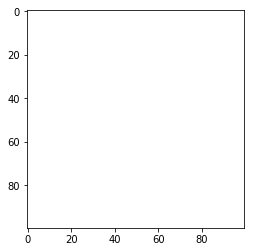

In [31]:
img = torch.zeros((100,100))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get a state of the double integrator

<p align="center">
  <img src="double_integrator_brick.svg" width="350"/>
</p>

In [32]:
## no necessary parameters
width  = 10.0 # width of brick in pixels
height = 5.0

## state

x    = 30.0 # position to right in pixels
xdot = 0.0  # 

state = torch.FloatTensor([x, xdot])
print state


 30
  0
[torch.FloatTensor of size 2]



## Convert state of double integrator to an AABB list of corners in img

In [33]:
center = torch.FloatTensor([0, state[0]])  # in world coordinates

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50

center_in_img = convert_world_to_img_coordinates(center)

lower_left  = center + torch.FloatTensor([0,      -width/2]) 
upper_left  = center + torch.FloatTensor([height, -width/2])
lower_right = center + torch.FloatTensor([0,       width/2])
upper_right = center + torch.FloatTensor([height,  width/2])

corners = [lower_left, upper_left, lower_right, upper_right]
corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]

## Find all pixels inside AABB


In [34]:
import numpy as np
pi = np.pi

In [35]:
def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]


def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()


def inside_aabb(aabb_corners, P):
    # check x conditions
    if (P[0] < aabb_corners[0][0]) or (P[0] > aabb_corners[3][0]):
        return False
    
    # check y conditions
    if (P[1] < aabb_corners[0][1]) or (P[1] > aabb_corners[3][1]):
        return False
    
    return True

def distance_to_aabb(aabb_corners, P):
    # if inside aabb, return 0
    distance_to_left   = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_top    = distance_pytorch(aabb_corners[1], aabb_corners[3], P)
    distance_to_right  = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_bottom = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    
    


## Render double integrator

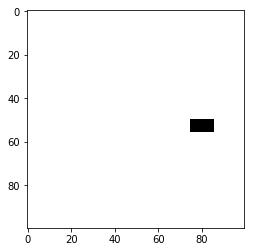

In [36]:
img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        if inside_aabb(corners_in_img, this_img_coord):
            img[i,j] = 1.0
        else:
            img[i,j] = 0.0

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get states of double integrator over time

In [37]:
def stabilize_origin_controller(state):
    x_desired = 0
    xdot_desired = 0
    diff_pos = (x_desired    - state[0])
    diff_vel = (xdot_desired - state[1])
    u = 1000*diff_pos + 100*diff_vel
    if u > 500:
        u = 500
    if u < -500:
        u = -500
    return u
    
def double_integrator_next_state(state, u):
    deriv = torch.zeros(2)
    deriv[0] = state[1]
    deriv[1] = u
    dt = .01
    next_state = state + deriv*dt
    return next_state

print state
print double_integrator_next_state(state,0)
print double_integrator_next_state(double_integrator_next_state(state,0),0)

state_tape = []
state_tape.append(state)

for i in range(100):
    u = stabilize_origin_controller(state_tape[-1])
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)

print state_tape[1]
print state_tape[6]


 30
  0
[torch.FloatTensor of size 2]


 30
  0
[torch.FloatTensor of size 2]


 30
  0
[torch.FloatTensor of size 2]

101

 30
 -5
[torch.FloatTensor of size 2]


 29.2500
-30.0000
[torch.FloatTensor of size 2]



In [38]:
def double_integrator_state_to_img(state):
    center = torch.FloatTensor([0, state[0]])  # in world coordinates
    center_in_img = convert_world_to_img_coordinates(center)

    lower_left  = center + torch.FloatTensor([0,      -width/2]) 
    upper_left  = center + torch.FloatTensor([height, -width/2])
    lower_right = center + torch.FloatTensor([0,       width/2])
    upper_right = center + torch.FloatTensor([height,  width/2])

    corners = [lower_left, upper_left, lower_right, upper_right]
    corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]
    
    img = torch.zeros((100,100))

    for i, row in enumerate(img):
        for j, val in enumerate(row):
            this_img_coord = torch.FloatTensor([i,j])
            if inside_aabb(corners_in_img, this_img_coord):
                img[i,j] = 1.0
            else:
                img[i,j] = 0.0

    return img


img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

101


In [39]:
# %matplotlib inline
# for i in img_tape:
#     plt.imshow(i, cmap=plt.get_cmap('gray_r'))
#     plt.show()

<IPython.core.display.Javascript object>


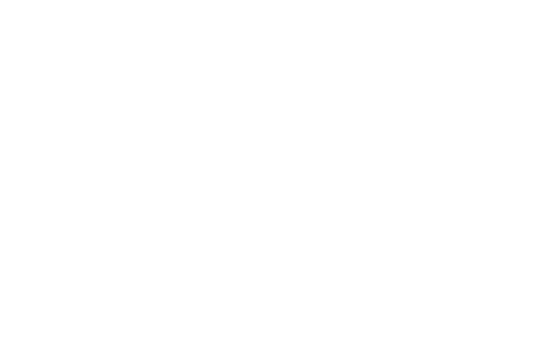

In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
first_img = img_tape[0]
im = plt.imshow(first_img, cmap='gist_gray_r')

def init():
    im.set_data(first_img)

def animate(i):
    im.set_data(img_tape[i])
    return im
    
animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
plt.close(fig)
HTML(animate.to_html5_video())

In [41]:
# plotting etc examples for reference
# https://gist.github.com/AndrewWalker/2687988
# https://matplotlib.org/examples/animation/double_pendulum_animated.html

## Optimization over output feedback policies

We would like to directly optimize an output feedback policy $\pi$, i.e.

\begin{align*}
        \min_{x(.), u(.), \pi} \ \ \ & \int_{t_0}^{t_f} g(x(t),u(t)) dt\\
        s.t. \ \ \  & \forall t, \ \ \dot{x}(t) = f(x(t),u(t)), \\
        & x(t_0) = x_0, \\
        & u = \pi(y(x))
\end{align*}

Where $y(x)$ is the renderer.

We would like to solve this optimization from many initial samples $x_{0,i}$ and simultaneously optimize the feedback policy given a particular form, for example linear feedback $u = Ky(x)$.



## Unconstrained "shooting" method optimization for linear feedback from one initial condition

For one initial condition $x_0$, linear feedback $u = Ky(x)$, and one choice of time horizon $t_f$, we can formulate this is a shooting method type optimization as follows:

\begin{align*}
        \min_{K} \ \ \ & \int_{t_0}^{t_f} g(x(t),u(t)) dt\\
        s.t. \ \ \  & \forall t, \ \ \dot{x}(t) = f(x(t),u(t)), \\
        & x(t_0) = x_0, \\
        & u = Ky(x)
\end{align*}

With our decision variables being only K, we can solve this from an initial guess and backpropagation.  This could work for any differentiable feedback policy $\pi$ but we can start with just linear feedback.

We'll use the simplest quadratic cost:

$$g(x(t), u(t)) = x^Tx + u^Tu $$

In [63]:
print torch.t(K).shape
print flat_img.shape

print (torch.t(K).mm(flat_img)).shape

torch.Size([1, 10000])
torch.Size([10000, 1])
torch.Size([1, 1])


In [77]:
### initial state and parameters

## parameters
width  = 10.0 # width of brick in pixels
height = 5.0

## state
x    = 30.0 # position to right in pixels
xdot = 0.0  # 

state_initial = torch.FloatTensor([x, xdot])


### time horizon

t_f = 100   # number of time steps

## renderer
def double_integrator_state_to_img(state):
    center = torch.FloatTensor([0, state[0]])  # in world coordinates
    center_in_img = convert_world_to_img_coordinates(center)

    lower_left  = center + torch.FloatTensor([0,      -width/2]) 
    upper_left  = center + torch.FloatTensor([height, -width/2])
    lower_right = center + torch.FloatTensor([0,       width/2])
    upper_right = center + torch.FloatTensor([height,  width/2])

    corners = [lower_left, upper_left, lower_right, upper_right]
    corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]
    
    img = torch.zeros((100,100))

    for i, row in enumerate(img):
        for j, val in enumerate(row):
            this_img_coord = torch.FloatTensor([i,j])
            if inside_aabb(corners_in_img, this_img_coord):
                img[i,j] = 1.0
            else:
                img[i,j] = 0.0

    return img


### feedback policy

## initial policy parameters
flat_img = img.view(-1,1)
K = torch.rand(flat_img.shape)

## policy
def output_feedback_policy(flat_img, K):
    return torch.t(K).mm(flat_img)
    
state_tape = []
state_tape.append(state_initial)
img_tape = []
img_tape.append(double_integrator_state_to_img(state_initial))
u_tape = []
    
### simulate initial policy
for i in range(t_f):
    y = img_tape[-1]
    flat_img = y.view(-1,1)
    u = output_feedback_policy(flat_img, K)
    next_state = double_integrator_next_state(state_tape[-1],u[0][0])
    state_tape.append(next_state)
    next_y     = double_integrator_state_to_img(next_state) 
    img_tape.append(next_y)
    u_tape.append(u)
    
print len(state_tape)
print len(img_tape)

## after the fact, go get the running cost
cost = 0
for i in state_tape[1:]:
    cost += i.pow(2).sum()
    
for i in u_tape:
    cost += i.pow(2).sum()
    
print cost

101
101
228095.853641


<IPython.core.display.Javascript object>


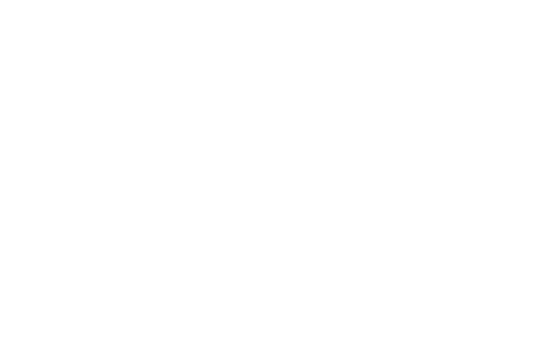

In [74]:
## visualize initial policy

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
first_img = img_tape[0]
im = plt.imshow(first_img, cmap='gist_gray_r')

def init():
    im.set_data(first_img)

def animate(i):
    im.set_data(img_tape[i])
    return im
    
animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
plt.close(fig)
HTML(animate.to_html5_video())

In [80]:
from torch.autograd import Variable

## optimize

num_iterations = 100
step_rate = 1e-6

state_initial = Variable(state_initial, requires_grad=False)
flat_img = img.view(-1,1)
K = Variable(torch.randn(flat_img.shape), requires_grad=True)

for i in range(num_iterations):
    
    state_tape = []
    
    state_tape.append(state_initial)
    img_tape = []
    img_tape.append(double_integrator_state_to_img(state_initial))
    u_tape = []
    
    ### simulate policy
    for i in range(t_f):
        y = img_tape[-1]
        flat_img = y.view(-1,1)
        u = output_feedback_policy(flat_img, K)
        next_state = double_integrator_next_state(state_tape[-1],u[0][0])
        state_tape.append(next_state)
        next_y     = double_integrator_state_to_img(next_state) 
        img_tape.append(next_y)
        u_tape.append(u)


    ## after the fact, go get the running cost
    cost = 0
    for i in state_tape[1:]:
        cost += i.pow(2).sum()

    for i in u_tape:
        cost += i.pow(2).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * w1.grad.data
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    
print K

RuntimeError: tried to construct a tensor from a float sequence, but found an item of type Variable at index (1)